In [1]:
######################################################################
#"Bottom-up" Introduction to Gen
#---------------------------------------------------------------------
#https://www.gen.dev/bottom-up/A%20Bottom-Up%20Introduction%20to%20Gen
######################################################################

using Gen: uniform_discrete, bernoulli, categorical

#Sample n, with probability p double it
#Return categorical variable with probability p: n, otherwise 1/19 for other digits in range(20)
function f(p)
    n = uniform_discrete(1, 10)
    if bernoulli(p)
        n *= 2
    end
    return categorical([i == n ? 0.5 : 0.5/19 for i=1:20])
end;

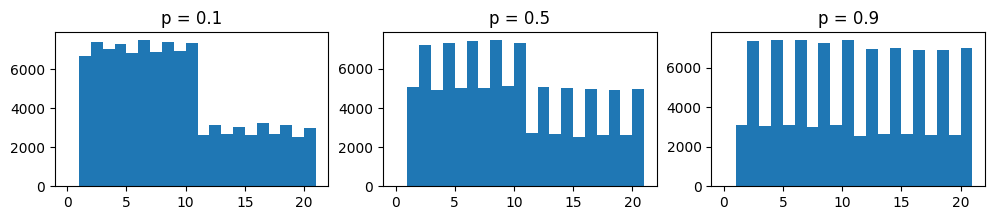

In [3]:
#Plot histogram of values
using PyPlot

bins = collect(range(0, 21, step=1))

function plot_histogram(p)
    hist([f(p) for _=1:100000], bins=bins)
    title("p = $p")
end

figure(figsize=(12, 2))

subplot(1, 3, 1)
plot_histogram(0.1)

subplot(1, 3, 2)
plot_histogram(0.5)

subplot(1, 3, 3)
plot_histogram(0.9);

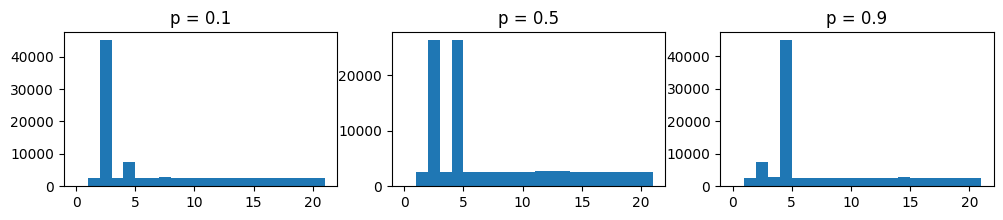

In [4]:
#Naively condition on n=2 and plot
function f_with_initial_n(p)
    initial_n = uniform_discrete(1, 10)
    n = initial_n
    if bernoulli(p)
        n *= 2
    end
    result = categorical([i == n ? 0.5 : 0.5/19 for i=1:20])
    return (result, initial_n)
end;

function plot_histogram_filtered(p)
    executions = 0
    results = []
    while executions < 100000
        (result, initial_n) = f_with_initial_n(p)
        if initial_n == 2
            push!(results, result)
            executions += 1
        end
    end
    hist(results, bins=bins)
    title("p = $p")
end;

figure(figsize=(12, 2))

subplot(1, 3, 1)
plot_histogram_filtered(0.1)

subplot(1, 3, 2)
plot_histogram_filtered(0.5)

subplot(1, 3, 3)
plot_histogram_filtered(0.9);

In [29]:
#With PPLs there is a better way to work with conditional distributions
#The trace is a record of all random choices. Naive implementation as a Dict:
function f_with_trace(p)
    trace = Dict()
    
    initial_n = uniform_discrete(1, 10)
    trace[:initial_n] = initial_n
    
    n = initial_n
    
    do_branch = bernoulli(p)
    trace[:do_branch] = do_branch
    
    if do_branch
        n *= 2
    end
    
    result = categorical([i == n ? 0.5 : 0.5/19 for i=1:20])
    trace[:result] = result
    
    return (result, trace)
end;

f_with_trace(0.3)

(13, Dict{Any,Any}(:result => 13,:do_branch => false,:initial_n => 7))

In [38]:
#Cleaning up the code a bit with an added function
#In Julia, the ! after a function means it may alter mutable arguments (i.e. increase the size of an array)
function add_to_trace!(trace, value, address)
    trace[address] = value
    return value
end

function f_with_trace_improved(p)
    trace = Dict()
    n = add_to_trace!(trace, uniform_discrete(1, 10), :initial_n)
    if add_to_trace!(trace, bernoulli(p), :do_branch)
        n *= 2
    end
    result = add_to_trace!(trace, categorical([i == n ? 0.5 : 0.5/19 for i=1:20]), :result)
    return (result, trace)
end;

f_with_trace_improved(0.3)

(17, Dict{Any,Any}(:result => 17,:do_branch => true,:initial_n => 4))

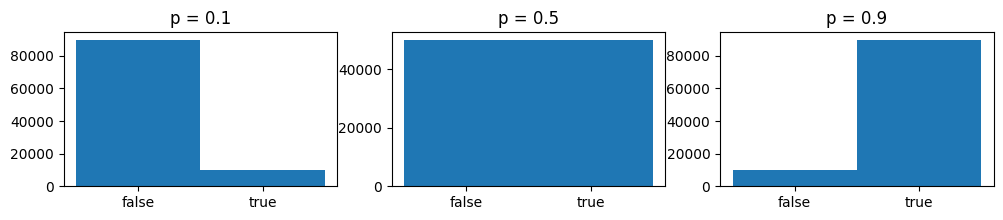

In [42]:
#We can ask conditioned questions now
#“What is the probability that the branch was taken, given that the result took the value 4?”

function query(p, observed_result_value::Int)
    executions = 0
    do_branch = []
    while executions < 100000
        (result, trace) = f_with_trace_improved(p)
        if trace[:result] == observed_result_value
            push!(do_branch, trace[:do_branch]) #do_branch.append(trace[do_branch]) like appending a Dict value
            executions += 1
        end
    end
    hist(do_branch, bins=[0, 1, 2], align="left")
    xticks([0, 1], ["false", "true"])
    title("p = $p")
end;


figure(figsize=(12, 2))

subplot(1, 3, 1)
query(0.1, 4)

subplot(1, 3, 2)
query(0.5, 4)

subplot(1, 3, 3)
query(0.9, 4);

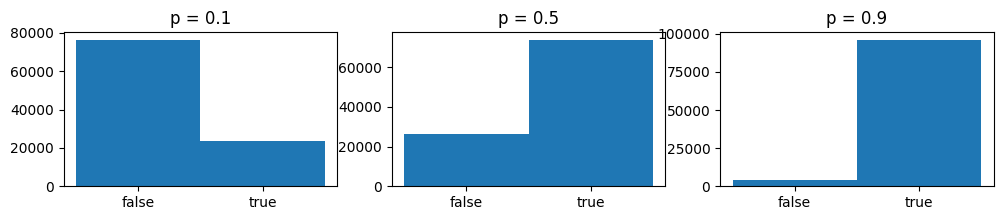

In [44]:
#For a result greater than 10, theoretically less likely
figure(figsize=(12, 2))

subplot(1, 3, 1)
query(0.1, 16)

subplot(1, 3, 2)
query(0.5, 16)

subplot(1, 3, 3)
query(0.9, 16);

In [47]:
##############################################################
#This is the motivation behind the trace data structure in Gen
##############################################################

using Gen: @gen, @trace

@gen function gen_f(p)
    n = @trace(uniform_discrete(1, 10), :initial_n)
    if @trace(bernoulli(p), :do_branch)
        n *= 2
    end
    return @trace(categorical([i == n ? 0.5 : 0.5/19 for i=1:20]), :result)
end;

using Gen: simulate
trace = simulate(gen_f, (0.3,));

trace[:initial_n]

7

In [56]:
#You can view all of the choices that were made in the execution of the program
using Gen: get_choices

#Use display to get nice Julia output, println for raw output
display(get_choices(trace))

#Initial arguments
using Gen: get_args

in_args = get_args(trace)
display(in_args)

#Return value
using Gen: get_retval

out_val = get_retval(trace)
display(out_val)

│
├── :result : 14
│
├── :do_branch : true
│
└── :initial_n : 7


(0.3,)

14

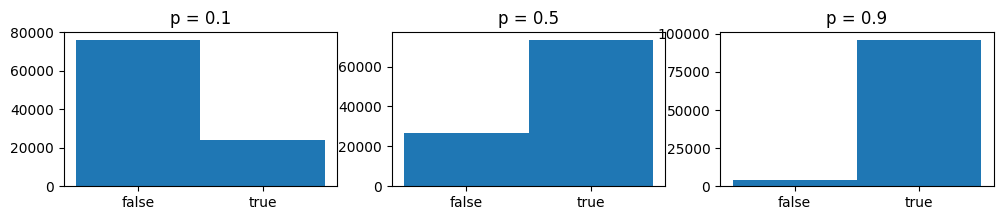

In [58]:
#The original question but with a Gen function
function gen_query(p, observed_result_value::Int)
    executions = 0
    do_branch = []
    while executions < 100000
        trace = simulate(gen_f, (p,))
        if trace[:result] == observed_result_value
            push!(do_branch, trace[:do_branch])
            executions += 1
        end
    end
    hist(do_branch, bins=[0, 1, 2], align="left")
    xticks([0, 1], ["false", "true"])
    title("p = $p")
end;

figure(figsize=(12, 2))

subplot(1, 3, 1)
query(0.1, 16)

subplot(1, 3, 2)
query(0.5, 16)

subplot(1, 3, 3)
query(0.9, 16);

In [97]:
#################################################################
#Representing a Probability Distribution by a Generative Function
#################################################################

@gen function foo(prob_a)
    val = true
    if @trace(bernoulli(prob_a), :a)
        val = @trace(bernoulli(0.6), :b) && val
    end
    prob_c = val ? 0.9 : 0.2
    val = @trace(bernoulli(prob_c), :c) && val
    return val
end;

prob_true(prob_a) = round(prob_a * 0.6 * 0.9 + (1-prob_a) * 0.9, digits=4);

for prob_a in [0.1, 0.5, 0.9]
    actual = sum([foo(prob_a) for _=1:10000]) / 10000
    println("expected: $(prob_true(prob_a)), actual: $actual")
end


expected: 0.864, actual: 0.8673
expected: 0.72, actual: 0.7132
expected: 0.576, actual: 0.583


In [142]:
#Log probability is obtained using get_score function
using Gen: get_score
trace = simulate(foo, (0.3,))
display(get_choices(trace))
println("log probability: $(get_score(trace))")

#Call trace address to get value, like a dictionary
trace[:a]

│
├── :a : true
│
├── :b : true
│
└── :c : true


log probability: -1.8201589437497532


true

In [144]:
################################
#Generating a constrained trace
################################

#Make your own choicemap with constraints
using Gen: choicemap

constraints = choicemap((:a, true), (:c, false))

display(constraints)

#This is equivalent to:
choices = choicemap()
choices[:a] = true
choices[:c] = false

│
├── :a : true
│
└── :c : false


false

In [181]:
#Generate function with constraints
using Gen: generate

(trace, weight) = generate(foo, (0.3,), constraints);

display(get_choices(trace))

get_retval(trace)

│
├── :a : true
│
├── :b : false
│
└── :c : false


false

In [183]:
#Weight is the log probability of the full distribution over the proposed distribution based on the constraint
#log [p(t;x) / q(t;x;u)] where t is the choicemap, x is the data, u is the constrained choice map
#Uses ancestral sampling in Gen
if trace[:b]
    # choice map is {a -> true, b -> true, c -> false}
    expected_weight = log(0.3 * 0.6 * 0.1 / 0.6)
else
    # choice map is {a -> true, b -> false, c -> false}
    expected_weight = log(0.3 * 0.4 * 0.8 / 0.4)
end
println("expected_weight: $expected_weight, actual_weight: $weight")

expected_weight: -1.4271163556401458, actual_weight: -1.4271163556401458


In [185]:
#Importance resampling
#Generates a collection of constrained traces and associated weights
#Returns a trace with probability in proportion to its weight
#Set number of traces to build a distribution over the conditions
#Naive implementation here, Gen has a built in function importance_resampling

function my_importance_sampler(gen_fn, args, constraints, num_traces)
    traces = []
    weights = []
    for i=1:num_traces
        (trace, weight) = generate(gen_fn, args, constraints)
        push!(traces, trace)
        push!(weights, weight)
    end
    
    # note: the weights are in log-space, so we exponentiate
    normalized_weights = exp.(weights) / sum(exp.(weights))
    idx = categorical(normalized_weights)
    return traces[idx]
    end;

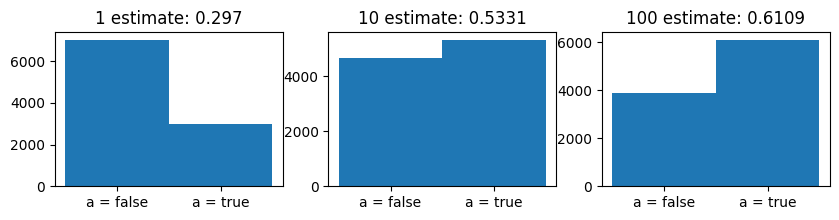

0.09782608695652173
0.5217391304347826
0.3804347826086956


0.6195652173913044

In [191]:
#Importance resampling for u = c: false
figure(figsize=(10, 2))

subplot(1, 3, 1)
as = []
for i=1:10000
    trace = my_importance_sampler(foo, (0.3,), choicemap((:c, false)), 1)
    push!(as, trace[:a])
end
hist(as, bins=[0, 1, 2], align="left")
xticks([0, 1], ["a = false", "a = true"]);
est_prob_a_true = sum(as) / 10000
title("1 estimate: $est_prob_a_true")

subplot(1, 3, 2)
as = []
for i=1:10000
    trace = my_importance_sampler(foo, (0.3,), choicemap((:c, false)), 10)
    push!(as, trace[:a])
end
hist(as, bins=[0, 1, 2], align="left")
xticks([0, 1], ["a = false", "a = true"]);
est_prob_a_true = sum(as) / 10000
title("10 estimate: $est_prob_a_true")

subplot(1, 3, 3)
as = []
for i=1:10000
    trace = my_importance_sampler(foo, (0.3,), choicemap((:c, false)), 100)
    push!(as, trace[:a])
end
hist(as, bins=[0, 1, 2], align="left")
xticks([0, 1], ["a = false", "a = true"]);
est_prob_a_true = sum(as) / 10000
title("100 estimate: $est_prob_a_true");

#Manual calculation
p1 = 0.3 * 0.6 * 0.1
p2 = 0.3 * 0.4 * 0.8
p3 = 0.7 * 0.1
p1 + p2 + p3
println(p1 / (p1 + p2 + p3))
println(p2 / (p1 + p2 + p3))
println(p3 / (p1 + p2 + p3))
prob_a_true = (p1 + p2) / (p1 + p2 + p3)

In [219]:
##################
#Updating a trace
##################

#A trace can conform to new constraints after it has been run
(trace, weight) = generate(foo, (0.3,), choicemap((:a, true), (:b, true), (:c, true)));
display(get_choices(trace))

#Update alters the choice map in place
using Gen: update, NoChange

constraints = choicemap((:c, false))
(new_trace, weight, discard, retdiff) = update(trace, (0.3,), (NoChange(),), constraints)
display(get_choices(new_trace))

#The update method also allows you to change the arguments to the function (from x to x′)
#Will be necessary in defining MCMC proposals

#Compare expected weight to actual
expected_weight = log(0.3 * 0.6 * 0.1) - log(0.3 * 0.6 * 0.9)
display(expected_weight)
display(weight)

│
├── :a : true
│
├── :b : true
│
└── :c : true


│
├── :a : true
│
├── :b : true
│
└── :c : false


-2.197224577336219

-2.1972245773362196

In [220]:
#Updating a trace may remove some addresses that are no longer reachable
#This is what we want for Reversible Jump MCMC!

(trace, weight, retdiff, discard) = update(trace, (0.3,), (NoChange(),), choicemap((:a, false)))
display(get_choices(trace))

display("choice :b has disappeared since :a is set to false")

#Discard is returned by update containing values for any addresses that were removed or constrained
display(discard)

│
├── :a : false
│
└── :c : true


"choice :b has disappeared since :a is set to false"

│
├── :a : true
│
└── :b : true


In [231]:
#If discard is applied as a constraint, the original choice map is returned
(trace, weight, retdiff, discard) = update(trace, (0.3,), (NoChange(),), discard);
display(get_choices(trace))

#And the new discard choice map contains the old constraints
display(discard)

│
├── :a : true
│
├── :b : true
│
└── :c : true


│
└── :a : false


In [ ]:
#From the tutorial, this illustrates reversibility. This functionality has been implemented in Gen
#with MCMC in mind. There are multiple RJMCMC resources implemented in Julia/Gen available on GitHub.